In [285]:
import lightgbm
import pandas as pd

part_1 = pd.read_csv("../../Data/dc_part_v3.csv")

In [286]:
part_2 = pd.read_csv("../../Data/chenqin5%.csv")
part_2.shape
part_2

,prgcontct_other_organisation_piv,prgcontct_lwb_worker_piv,prgcontct_both_client_and_carer_piv,prgcontct_department_piv,prgcontct_family_piv,prgcontct_carer_piv,prgcontct_client_piv,prgcontct_meeting_group_of_people_piv_sum_n_days,prgcontct_other_organisation_piv_sum_n_days,prgcontct_educational_institution_piv_sum_n_days,...,progsubjcat_youth_justice_summary_report_piv_days_since,progsubjcat_training_and_development_piv_days_since,progsubjcat_annual_review_piv_days_since,progsubjcat_monthly_report_piv_days_since,progsubjcat_biological_family_carer_piv_days_since,progsubjcat_extra_curricular_activities_piv_days_since,progsubjcat_household_dynamics_piv_days_since,progsubjcat_direct_support_shift_report_piv_days_since,progsubjcat_other_piv_days_since,client_status_active_piv
0,0,0,0,0,1,0,0,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,28
1,0,0,0,0,0,0,0,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,31
2,0,0,0,0,0,0,0,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,30
3,0,0,0,0,0,0,1,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,31
4,0,0,0,0,0,0,2,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124288,0,0,0,1,0,0,0,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,30
124289,0,0,0,0,0,0,1,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,31
124290,0,0,0,0,0,0,1,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,30
124291,0,0,0,0,0,0,1,0.0,0.0,0.0,...,3650,3650,3650,3650,3650,3650,3650,3650,3650,31


In [312]:
init_record = pd.concat([part_1, part_2], axis=1, sort=False)
init_record.head()
init_record = pd.concat([init_record.filter(regex=r'_piv$', axis=1), 
                         init_record['_key_occurreddate_month'], 
                         init_record['_key_client_id'],
                         init_record['response_variable']], axis=1, sort=False)
print(init_record.shape)

(124293, 159)


In [313]:

#init_record = pd.concat([part_1, part_2], axis=1, sort=False)
init_record['_key_occurreddate_month']=init_record['_key_occurreddate_month'].astype("datetime64[ns]")
init_record = init_record.set_index(['_key_client_id', '_key_occurreddate_month'])

## Split Dataset to three part: Training, evaluation and testing data

In [314]:
from collections import Counter
count = Counter()
for i in init_record.index.get_level_values(0):
    count[i] += 1
count.most_common(1)

[('0000D172-EA88-432F-8235-9FAA00D29072', 12)]

## Construct feature Matrix with length k (k must smaller then n-1)

In [315]:
n = 6
deleteList = []
for i in count:
    if count[i] < n:
        deleteList.append(i)

In [316]:
init_record.drop(deleteList, inplace=True, level=0)

In [317]:
import random
clientList = list(set(init_record.index.get_level_values(0)))

In [318]:
random.shuffle(clientList)

In [319]:
length = len(clientList)
ratio = int(length*0.1)
trainIDs = clientList[ratio:]
testIDs = clientList[:ratio]
train0 = init_record.drop(testIDs, level=0)
test = init_record.drop(trainIDs, level=0)

In [320]:
print(train0.shape)
print(test.shape)

(101969, 157)
(11343, 157)


In [321]:
ratio = int(len(trainIDs)*0.25)
trainRatio = trainIDs[ratio:]
evalRatio  = trainIDs[:ratio]
train = train0.drop(evalRatio, level=0)
evl = train0.drop(trainRatio,level=0)

In [322]:
print(train.shape)
print(evl.shape)
print(test.shape)

(76412, 157)
(25557, 157)
(11343, 157)


## Construct feature Matrix with length k (k must smaller then n-1)

In [323]:
import numpy as np

In [373]:

def construct_feature_label(data,k=6):
    x_train = []
    y_train = []
    clientList = list(set(data.index.get_level_values(0)))
    for client in clientList:
        subframe = data.xs(client, level=0)
        subtrain = subframe.drop('response_variable',axis='columns')
        sublabel = subframe['response_variable']
        start = 0
        end = k
        while end<len(subframe)-1:
            x_train.append(subtrain[start:end].values)
            y_train.append(sublabel[end+1])
            end+=1
            start+=1
    return x_train, y_train

x_train ,y_train = construct_feature_label(train)
x_eval, y_eval = construct_feature_label(evl)

In [374]:
print(len(x_train))
print(len(y_train))
print(len(x_train[0]))
print(len(x_train[0][0]))
x_train = np.array(x_train)
x_eval = np.array(x_eval)

28065
28065
6
156


In [375]:
def reshape_featrue_label(x, y):
    new_y = []
    for i in y:
        new_y+=[i]*len(x[0])
    x = x.reshape(len(x)*len(x[0]),len(x[0][0]))
    new_y = np.array(new_y)
    return x, new_y

x_train ,y_train = reshape_featrue_label(x_train ,y_train)
x_eval, y_eval = reshape_featrue_label(x_eval, y_eval)

In [376]:
print(x_train.shape)
print(y_train.shape)

(168390, 156)
(168390,)


In [377]:
print(x_eval.shape)
print(y_eval.shape)

(56652, 156)
(56652,)


In [378]:
for i in range(len(x_train)-1):
    if len(x_train[i+1])!=len(x_train[i]):
        print(1)

In [379]:
train_data = lightgbm.Dataset(x_train, label=y_train)
eval_data = lightgbm.Dataset(x_eval, label=y_eval)

In [405]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'rf',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


In [406]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=eval_data,
                       num_boost_round=5000,)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's auc: 0.817631
[2]	valid_0's auc: 0.823616
[3]	valid_0's auc: 0.823153
[4]	valid_0's auc: 0.82493
[5]	valid_0's auc: 0.824581
[6]	valid_0's auc: 0.824307
[7]	valid_0's auc: 0.824154
[8]	va

[256]	valid_0's auc: 0.826072
[257]	valid_0's auc: 0.826062
[258]	valid_0's auc: 0.826077
[259]	valid_0's auc: 0.826078
[260]	valid_0's auc: 0.826074
[261]	valid_0's auc: 0.826088
[262]	valid_0's auc: 0.826022
[263]	valid_0's auc: 0.826063
[264]	valid_0's auc: 0.82606
[265]	valid_0's auc: 0.826106
[266]	valid_0's auc: 0.826042
[267]	valid_0's auc: 0.826105
[268]	valid_0's auc: 0.826092
[269]	valid_0's auc: 0.826153
[270]	valid_0's auc: 0.826067
[271]	valid_0's auc: 0.826065
[272]	valid_0's auc: 0.826071
[273]	valid_0's auc: 0.826088
[274]	valid_0's auc: 0.826101
[275]	valid_0's auc: 0.826107
[276]	valid_0's auc: 0.825917
[277]	valid_0's auc: 0.825924
[278]	valid_0's auc: 0.825935
[279]	valid_0's auc: 0.825946
[280]	valid_0's auc: 0.825931
[281]	valid_0's auc: 0.825913
[282]	valid_0's auc: 0.825944
[283]	valid_0's auc: 0.826012
[284]	valid_0's auc: 0.825984
[285]	valid_0's auc: 0.825933
[286]	valid_0's auc: 0.825957
[287]	valid_0's auc: 0.825955
[288]	valid_0's auc: 0.825963
[289]	valid

[536]	valid_0's auc: 0.826084
[537]	valid_0's auc: 0.82609
[538]	valid_0's auc: 0.82608
[539]	valid_0's auc: 0.826075
[540]	valid_0's auc: 0.826091
[541]	valid_0's auc: 0.826131
[542]	valid_0's auc: 0.826086
[543]	valid_0's auc: 0.826088
[544]	valid_0's auc: 0.826092
[545]	valid_0's auc: 0.826086
[546]	valid_0's auc: 0.826091
[547]	valid_0's auc: 0.826047
[548]	valid_0's auc: 0.826048
[549]	valid_0's auc: 0.826047
[550]	valid_0's auc: 0.826052
[551]	valid_0's auc: 0.826093
[552]	valid_0's auc: 0.826015
[553]	valid_0's auc: 0.825996
[554]	valid_0's auc: 0.826051
[555]	valid_0's auc: 0.826049
[556]	valid_0's auc: 0.826062
[557]	valid_0's auc: 0.826073
[558]	valid_0's auc: 0.826062
[559]	valid_0's auc: 0.826047
[560]	valid_0's auc: 0.826049
[561]	valid_0's auc: 0.826045
[562]	valid_0's auc: 0.826017
[563]	valid_0's auc: 0.826047
[564]	valid_0's auc: 0.826088
[565]	valid_0's auc: 0.826095
[566]	valid_0's auc: 0.826071
[567]	valid_0's auc: 0.826075
[568]	valid_0's auc: 0.826081
[569]	valid_

[811]	valid_0's auc: 0.826192
[812]	valid_0's auc: 0.82619
[813]	valid_0's auc: 0.826119
[814]	valid_0's auc: 0.826129
[815]	valid_0's auc: 0.826128
[816]	valid_0's auc: 0.826127
[817]	valid_0's auc: 0.82613
[818]	valid_0's auc: 0.826129
[819]	valid_0's auc: 0.826134
[820]	valid_0's auc: 0.826149
[821]	valid_0's auc: 0.826168
[822]	valid_0's auc: 0.826169
[823]	valid_0's auc: 0.826151
[824]	valid_0's auc: 0.826144
[825]	valid_0's auc: 0.82617
[826]	valid_0's auc: 0.826176
[827]	valid_0's auc: 0.826164
[828]	valid_0's auc: 0.826168
[829]	valid_0's auc: 0.826168
[830]	valid_0's auc: 0.826157
[831]	valid_0's auc: 0.826143
[832]	valid_0's auc: 0.826142
[833]	valid_0's auc: 0.826156
[834]	valid_0's auc: 0.826159
[835]	valid_0's auc: 0.826154
[836]	valid_0's auc: 0.826153
[837]	valid_0's auc: 0.826167
[838]	valid_0's auc: 0.826173
[839]	valid_0's auc: 0.826168
[840]	valid_0's auc: 0.826179
[841]	valid_0's auc: 0.82617
[842]	valid_0's auc: 0.826175
[843]	valid_0's auc: 0.826165
[844]	valid_0'

[1083]	valid_0's auc: 0.826126
[1084]	valid_0's auc: 0.826035
[1085]	valid_0's auc: 0.826034
[1086]	valid_0's auc: 0.826034
[1087]	valid_0's auc: 0.82603
[1088]	valid_0's auc: 0.826033
[1089]	valid_0's auc: 0.826044
[1090]	valid_0's auc: 0.826041
[1091]	valid_0's auc: 0.826035
[1092]	valid_0's auc: 0.82603
[1093]	valid_0's auc: 0.826028
[1094]	valid_0's auc: 0.82605
[1095]	valid_0's auc: 0.826041
[1096]	valid_0's auc: 0.826046
[1097]	valid_0's auc: 0.826046
[1098]	valid_0's auc: 0.826046
[1099]	valid_0's auc: 0.826046
[1100]	valid_0's auc: 0.825902
[1101]	valid_0's auc: 0.825903
[1102]	valid_0's auc: 0.826041
[1103]	valid_0's auc: 0.826037
[1104]	valid_0's auc: 0.826034
[1105]	valid_0's auc: 0.826044
[1106]	valid_0's auc: 0.826043
[1107]	valid_0's auc: 0.826038
[1108]	valid_0's auc: 0.826038
[1109]	valid_0's auc: 0.826035
[1110]	valid_0's auc: 0.826015
[1111]	valid_0's auc: 0.826098
[1112]	valid_0's auc: 0.826093
[1113]	valid_0's auc: 0.826095
[1114]	valid_0's auc: 0.826088
[1115]	vali

[1352]	valid_0's auc: 0.825777
[1353]	valid_0's auc: 0.825778
[1354]	valid_0's auc: 0.825778
[1355]	valid_0's auc: 0.825808
[1356]	valid_0's auc: 0.825806
[1357]	valid_0's auc: 0.825801
[1358]	valid_0's auc: 0.825807
[1359]	valid_0's auc: 0.825763
[1360]	valid_0's auc: 0.825797
[1361]	valid_0's auc: 0.82579
[1362]	valid_0's auc: 0.825761
[1363]	valid_0's auc: 0.825799
[1364]	valid_0's auc: 0.82576
[1365]	valid_0's auc: 0.825755
[1366]	valid_0's auc: 0.825758
[1367]	valid_0's auc: 0.825769
[1368]	valid_0's auc: 0.825754
[1369]	valid_0's auc: 0.825762
[1370]	valid_0's auc: 0.825755
[1371]	valid_0's auc: 0.825756
[1372]	valid_0's auc: 0.825757
[1373]	valid_0's auc: 0.825795
[1374]	valid_0's auc: 0.825812
[1375]	valid_0's auc: 0.82575
[1376]	valid_0's auc: 0.825721
[1377]	valid_0's auc: 0.825729
[1378]	valid_0's auc: 0.825733
[1379]	valid_0's auc: 0.825712
[1380]	valid_0's auc: 0.825766
[1381]	valid_0's auc: 0.825767
[1382]	valid_0's auc: 0.82576
[1383]	valid_0's auc: 0.825723
[1384]	valid

[1618]	valid_0's auc: 0.82596
[1619]	valid_0's auc: 0.825961
[1620]	valid_0's auc: 0.825927
[1621]	valid_0's auc: 0.825922
[1622]	valid_0's auc: 0.825923
[1623]	valid_0's auc: 0.825925
[1624]	valid_0's auc: 0.825918
[1625]	valid_0's auc: 0.82592
[1626]	valid_0's auc: 0.82592
[1627]	valid_0's auc: 0.825911
[1628]	valid_0's auc: 0.825912
[1629]	valid_0's auc: 0.825947
[1630]	valid_0's auc: 0.825951
[1631]	valid_0's auc: 0.825951
[1632]	valid_0's auc: 0.825951
[1633]	valid_0's auc: 0.82596
[1634]	valid_0's auc: 0.825958
[1635]	valid_0's auc: 0.825956
[1636]	valid_0's auc: 0.825956
[1637]	valid_0's auc: 0.825925
[1638]	valid_0's auc: 0.825924
[1639]	valid_0's auc: 0.825927
[1640]	valid_0's auc: 0.825928
[1641]	valid_0's auc: 0.825928
[1642]	valid_0's auc: 0.825928
[1643]	valid_0's auc: 0.82593
[1644]	valid_0's auc: 0.82593
[1645]	valid_0's auc: 0.82593
[1646]	valid_0's auc: 0.825931
[1647]	valid_0's auc: 0.825916
[1648]	valid_0's auc: 0.825917
[1649]	valid_0's auc: 0.825924
[1650]	valid_0'

[1885]	valid_0's auc: 0.826082
[1886]	valid_0's auc: 0.826081
[1887]	valid_0's auc: 0.826083
[1888]	valid_0's auc: 0.826087
[1889]	valid_0's auc: 0.826088
[1890]	valid_0's auc: 0.826089
[1891]	valid_0's auc: 0.826087
[1892]	valid_0's auc: 0.826087
[1893]	valid_0's auc: 0.826087
[1894]	valid_0's auc: 0.826096
[1895]	valid_0's auc: 0.826096
[1896]	valid_0's auc: 0.826095
[1897]	valid_0's auc: 0.826096
[1898]	valid_0's auc: 0.826094
[1899]	valid_0's auc: 0.826094
[1900]	valid_0's auc: 0.825948
[1901]	valid_0's auc: 0.825949
[1902]	valid_0's auc: 0.825949
[1903]	valid_0's auc: 0.825949
[1904]	valid_0's auc: 0.825954
[1905]	valid_0's auc: 0.825957
[1906]	valid_0's auc: 0.825931
[1907]	valid_0's auc: 0.82593
[1908]	valid_0's auc: 0.82593
[1909]	valid_0's auc: 0.825953
[1910]	valid_0's auc: 0.825932
[1911]	valid_0's auc: 0.825929
[1912]	valid_0's auc: 0.825929
[1913]	valid_0's auc: 0.825928
[1914]	valid_0's auc: 0.825928
[1915]	valid_0's auc: 0.825925
[1916]	valid_0's auc: 0.825916
[1917]	val

[2151]	valid_0's auc: 0.825953
[2152]	valid_0's auc: 0.825954
[2153]	valid_0's auc: 0.825957
[2154]	valid_0's auc: 0.825953
[2155]	valid_0's auc: 0.825953
[2156]	valid_0's auc: 0.825953
[2157]	valid_0's auc: 0.825953
[2158]	valid_0's auc: 0.825952
[2159]	valid_0's auc: 0.825953
[2160]	valid_0's auc: 0.825954
[2161]	valid_0's auc: 0.825954
[2162]	valid_0's auc: 0.825953
[2163]	valid_0's auc: 0.825954
[2164]	valid_0's auc: 0.825951
[2165]	valid_0's auc: 0.825951
[2166]	valid_0's auc: 0.825943
[2167]	valid_0's auc: 0.825944
[2168]	valid_0's auc: 0.825952
[2169]	valid_0's auc: 0.825803
[2170]	valid_0's auc: 0.825803
[2171]	valid_0's auc: 0.825807
[2172]	valid_0's auc: 0.82581
[2173]	valid_0's auc: 0.825809
[2174]	valid_0's auc: 0.825809
[2175]	valid_0's auc: 0.825808
[2176]	valid_0's auc: 0.825813
[2177]	valid_0's auc: 0.82581
[2178]	valid_0's auc: 0.825814
[2179]	valid_0's auc: 0.825813
[2180]	valid_0's auc: 0.825813
[2181]	valid_0's auc: 0.825815
[2182]	valid_0's auc: 0.825814
[2183]	val

[2417]	valid_0's auc: 0.826055
[2418]	valid_0's auc: 0.826054
[2419]	valid_0's auc: 0.826058
[2420]	valid_0's auc: 0.826062
[2421]	valid_0's auc: 0.826059
[2422]	valid_0's auc: 0.826063
[2423]	valid_0's auc: 0.826056
[2424]	valid_0's auc: 0.826052
[2425]	valid_0's auc: 0.826055
[2426]	valid_0's auc: 0.826057
[2427]	valid_0's auc: 0.826061
[2428]	valid_0's auc: 0.826085
[2429]	valid_0's auc: 0.826086
[2430]	valid_0's auc: 0.826087
[2431]	valid_0's auc: 0.826088
[2432]	valid_0's auc: 0.82609
[2433]	valid_0's auc: 0.826087
[2434]	valid_0's auc: 0.826087
[2435]	valid_0's auc: 0.826087
[2436]	valid_0's auc: 0.826091
[2437]	valid_0's auc: 0.826088
[2438]	valid_0's auc: 0.826087
[2439]	valid_0's auc: 0.826077
[2440]	valid_0's auc: 0.826056
[2441]	valid_0's auc: 0.826065
[2442]	valid_0's auc: 0.826063
[2443]	valid_0's auc: 0.826086
[2444]	valid_0's auc: 0.826064
[2445]	valid_0's auc: 0.826063
[2446]	valid_0's auc: 0.826064
[2447]	valid_0's auc: 0.826064
[2448]	valid_0's auc: 0.826091
[2449]	va

[2689]	valid_0's auc: 0.825912
[2690]	valid_0's auc: 0.826
[2691]	valid_0's auc: 0.825917
[2692]	valid_0's auc: 0.825923
[2693]	valid_0's auc: 0.825919
[2694]	valid_0's auc: 0.825917
[2695]	valid_0's auc: 0.825916
[2696]	valid_0's auc: 0.825916
[2697]	valid_0's auc: 0.825916
[2698]	valid_0's auc: 0.825915
[2699]	valid_0's auc: 0.825917
[2700]	valid_0's auc: 0.825917
[2701]	valid_0's auc: 0.825932
[2702]	valid_0's auc: 0.825919
[2703]	valid_0's auc: 0.82592
[2704]	valid_0's auc: 0.825921
[2705]	valid_0's auc: 0.82592
[2706]	valid_0's auc: 0.82592
[2707]	valid_0's auc: 0.825913
[2708]	valid_0's auc: 0.825913
[2709]	valid_0's auc: 0.825913
[2710]	valid_0's auc: 0.826012
[2711]	valid_0's auc: 0.826013
[2712]	valid_0's auc: 0.825912
[2713]	valid_0's auc: 0.825909
[2714]	valid_0's auc: 0.825911
[2715]	valid_0's auc: 0.825909
[2716]	valid_0's auc: 0.825914
[2717]	valid_0's auc: 0.825918
[2718]	valid_0's auc: 0.825922
[2719]	valid_0's auc: 0.82592
[2720]	valid_0's auc: 0.825917
[2721]	valid_0'

[2959]	valid_0's auc: 0.825889
[2960]	valid_0's auc: 0.825884
[2961]	valid_0's auc: 0.825883
[2962]	valid_0's auc: 0.825886
[2963]	valid_0's auc: 0.825894
[2964]	valid_0's auc: 0.825893
[2965]	valid_0's auc: 0.825886
[2966]	valid_0's auc: 0.825885
[2967]	valid_0's auc: 0.825892
[2968]	valid_0's auc: 0.825891
[2969]	valid_0's auc: 0.825891
[2970]	valid_0's auc: 0.825895
[2971]	valid_0's auc: 0.825895
[2972]	valid_0's auc: 0.825894
[2973]	valid_0's auc: 0.825895
[2974]	valid_0's auc: 0.825896
[2975]	valid_0's auc: 0.825896
[2976]	valid_0's auc: 0.825897
[2977]	valid_0's auc: 0.825892
[2978]	valid_0's auc: 0.825894
[2979]	valid_0's auc: 0.825892
[2980]	valid_0's auc: 0.825894
[2981]	valid_0's auc: 0.825894
[2982]	valid_0's auc: 0.825893
[2983]	valid_0's auc: 0.825895
[2984]	valid_0's auc: 0.825896
[2985]	valid_0's auc: 0.825895
[2986]	valid_0's auc: 0.825895
[2987]	valid_0's auc: 0.825895
[2988]	valid_0's auc: 0.825896
[2989]	valid_0's auc: 0.825893
[2990]	valid_0's auc: 0.825894
[2991]	v

[3232]	valid_0's auc: 0.825856
[3233]	valid_0's auc: 0.825854
[3234]	valid_0's auc: 0.82585
[3235]	valid_0's auc: 0.82585
[3236]	valid_0's auc: 0.82585
[3237]	valid_0's auc: 0.825851
[3238]	valid_0's auc: 0.825842
[3239]	valid_0's auc: 0.825849
[3240]	valid_0's auc: 0.825851
[3241]	valid_0's auc: 0.825852
[3242]	valid_0's auc: 0.825851
[3243]	valid_0's auc: 0.825851
[3244]	valid_0's auc: 0.825851
[3245]	valid_0's auc: 0.825848
[3246]	valid_0's auc: 0.825852
[3247]	valid_0's auc: 0.825855
[3248]	valid_0's auc: 0.82585
[3249]	valid_0's auc: 0.825849
[3250]	valid_0's auc: 0.825845
[3251]	valid_0's auc: 0.82584
[3252]	valid_0's auc: 0.82584
[3253]	valid_0's auc: 0.82584
[3254]	valid_0's auc: 0.825841
[3255]	valid_0's auc: 0.82584
[3256]	valid_0's auc: 0.825839
[3257]	valid_0's auc: 0.82584
[3258]	valid_0's auc: 0.825839
[3259]	valid_0's auc: 0.82584
[3260]	valid_0's auc: 0.825841
[3261]	valid_0's auc: 0.825842
[3262]	valid_0's auc: 0.825841
[3263]	valid_0's auc: 0.825842
[3264]	valid_0's a

[3501]	valid_0's auc: 0.826029
[3502]	valid_0's auc: 0.826029
[3503]	valid_0's auc: 0.826034
[3504]	valid_0's auc: 0.826035
[3505]	valid_0's auc: 0.826024
[3506]	valid_0's auc: 0.826025
[3507]	valid_0's auc: 0.826026
[3508]	valid_0's auc: 0.826025
[3509]	valid_0's auc: 0.826026
[3510]	valid_0's auc: 0.826035
[3511]	valid_0's auc: 0.826038
[3512]	valid_0's auc: 0.826036
[3513]	valid_0's auc: 0.826027
[3514]	valid_0's auc: 0.826034
[3515]	valid_0's auc: 0.826034
[3516]	valid_0's auc: 0.826033
[3517]	valid_0's auc: 0.826034
[3518]	valid_0's auc: 0.826033
[3519]	valid_0's auc: 0.826037
[3520]	valid_0's auc: 0.826034
[3521]	valid_0's auc: 0.826035
[3522]	valid_0's auc: 0.826036
[3523]	valid_0's auc: 0.826035
[3524]	valid_0's auc: 0.826039
[3525]	valid_0's auc: 0.826039
[3526]	valid_0's auc: 0.826035
[3527]	valid_0's auc: 0.825953
[3528]	valid_0's auc: 0.825951
[3529]	valid_0's auc: 0.825949
[3530]	valid_0's auc: 0.825949
[3531]	valid_0's auc: 0.825946
[3532]	valid_0's auc: 0.825946
[3533]	v

[3771]	valid_0's auc: 0.82597
[3772]	valid_0's auc: 0.825971
[3773]	valid_0's auc: 0.825972
[3774]	valid_0's auc: 0.825971
[3775]	valid_0's auc: 0.825967
[3776]	valid_0's auc: 0.825966
[3777]	valid_0's auc: 0.825966
[3778]	valid_0's auc: 0.825966
[3779]	valid_0's auc: 0.825968
[3780]	valid_0's auc: 0.825968
[3781]	valid_0's auc: 0.825968
[3782]	valid_0's auc: 0.825968
[3783]	valid_0's auc: 0.82597
[3784]	valid_0's auc: 0.82597
[3785]	valid_0's auc: 0.82597
[3786]	valid_0's auc: 0.825969
[3787]	valid_0's auc: 0.825973
[3788]	valid_0's auc: 0.825972
[3789]	valid_0's auc: 0.82597
[3790]	valid_0's auc: 0.82597
[3791]	valid_0's auc: 0.825972
[3792]	valid_0's auc: 0.825969
[3793]	valid_0's auc: 0.825968
[3794]	valid_0's auc: 0.825966
[3795]	valid_0's auc: 0.825963
[3796]	valid_0's auc: 0.825963
[3797]	valid_0's auc: 0.825961
[3798]	valid_0's auc: 0.825962
[3799]	valid_0's auc: 0.825963
[3800]	valid_0's auc: 0.825965
[3801]	valid_0's auc: 0.825964
[3802]	valid_0's auc: 0.825964
[3803]	valid_0

[4040]	valid_0's auc: 0.826032
[4041]	valid_0's auc: 0.826033
[4042]	valid_0's auc: 0.826006
[4043]	valid_0's auc: 0.826008
[4044]	valid_0's auc: 0.826007
[4045]	valid_0's auc: 0.826008
[4046]	valid_0's auc: 0.826004
[4047]	valid_0's auc: 0.826003
[4048]	valid_0's auc: 0.826
[4049]	valid_0's auc: 0.826
[4050]	valid_0's auc: 0.826001
[4051]	valid_0's auc: 0.825999
[4052]	valid_0's auc: 0.825997
[4053]	valid_0's auc: 0.825999
[4054]	valid_0's auc: 0.826
[4055]	valid_0's auc: 0.825999
[4056]	valid_0's auc: 0.825999
[4057]	valid_0's auc: 0.825999
[4058]	valid_0's auc: 0.826006
[4059]	valid_0's auc: 0.826006
[4060]	valid_0's auc: 0.825999
[4061]	valid_0's auc: 0.826006
[4062]	valid_0's auc: 0.826008
[4063]	valid_0's auc: 0.825999
[4064]	valid_0's auc: 0.826003
[4065]	valid_0's auc: 0.82601
[4066]	valid_0's auc: 0.826008
[4067]	valid_0's auc: 0.826002
[4068]	valid_0's auc: 0.826008
[4069]	valid_0's auc: 0.825996
[4070]	valid_0's auc: 0.826008
[4071]	valid_0's auc: 0.826009
[4072]	valid_0's a

[4310]	valid_0's auc: 0.826009
[4311]	valid_0's auc: 0.826009
[4312]	valid_0's auc: 0.825999
[4313]	valid_0's auc: 0.826011
[4314]	valid_0's auc: 0.826001
[4315]	valid_0's auc: 0.826007
[4316]	valid_0's auc: 0.826007
[4317]	valid_0's auc: 0.826005
[4318]	valid_0's auc: 0.826005
[4319]	valid_0's auc: 0.826004
[4320]	valid_0's auc: 0.826004
[4321]	valid_0's auc: 0.826004
[4322]	valid_0's auc: 0.826004
[4323]	valid_0's auc: 0.826006
[4324]	valid_0's auc: 0.826005
[4325]	valid_0's auc: 0.825989
[4326]	valid_0's auc: 0.826009
[4327]	valid_0's auc: 0.826008
[4328]	valid_0's auc: 0.825988
[4329]	valid_0's auc: 0.825988
[4330]	valid_0's auc: 0.826008
[4331]	valid_0's auc: 0.826008
[4332]	valid_0's auc: 0.826009
[4333]	valid_0's auc: 0.826009
[4334]	valid_0's auc: 0.826011
[4335]	valid_0's auc: 0.826003
[4336]	valid_0's auc: 0.825983
[4337]	valid_0's auc: 0.825983
[4338]	valid_0's auc: 0.825983
[4339]	valid_0's auc: 0.825983
[4340]	valid_0's auc: 0.825983
[4341]	valid_0's auc: 0.825983
[4342]	v

[4577]	valid_0's auc: 0.825931
[4578]	valid_0's auc: 0.825931
[4579]	valid_0's auc: 0.825931
[4580]	valid_0's auc: 0.825935
[4581]	valid_0's auc: 0.825938
[4582]	valid_0's auc: 0.825938
[4583]	valid_0's auc: 0.825938
[4584]	valid_0's auc: 0.825939
[4585]	valid_0's auc: 0.825937
[4586]	valid_0's auc: 0.825933
[4587]	valid_0's auc: 0.825937
[4588]	valid_0's auc: 0.825936
[4589]	valid_0's auc: 0.825937
[4590]	valid_0's auc: 0.825936
[4591]	valid_0's auc: 0.825931
[4592]	valid_0's auc: 0.82593
[4593]	valid_0's auc: 0.825931
[4594]	valid_0's auc: 0.82593
[4595]	valid_0's auc: 0.825931
[4596]	valid_0's auc: 0.82593
[4597]	valid_0's auc: 0.825929
[4598]	valid_0's auc: 0.82593
[4599]	valid_0's auc: 0.82593
[4600]	valid_0's auc: 0.82593
[4601]	valid_0's auc: 0.82593
[4602]	valid_0's auc: 0.825933
[4603]	valid_0's auc: 0.825931
[4604]	valid_0's auc: 0.825932
[4605]	valid_0's auc: 0.825931
[4606]	valid_0's auc: 0.82593
[4607]	valid_0's auc: 0.825931
[4608]	valid_0's auc: 0.825929
[4609]	valid_0's

[4848]	valid_0's auc: 0.825975
[4849]	valid_0's auc: 0.825975
[4850]	valid_0's auc: 0.825975
[4851]	valid_0's auc: 0.825975
[4852]	valid_0's auc: 0.825971
[4853]	valid_0's auc: 0.825971
[4854]	valid_0's auc: 0.825969
[4855]	valid_0's auc: 0.825968
[4856]	valid_0's auc: 0.825969
[4857]	valid_0's auc: 0.82597
[4858]	valid_0's auc: 0.82597
[4859]	valid_0's auc: 0.82597
[4860]	valid_0's auc: 0.82597
[4861]	valid_0's auc: 0.825969
[4862]	valid_0's auc: 0.825967
[4863]	valid_0's auc: 0.825967
[4864]	valid_0's auc: 0.825967
[4865]	valid_0's auc: 0.825966
[4866]	valid_0's auc: 0.825965
[4867]	valid_0's auc: 0.825965
[4868]	valid_0's auc: 0.825965
[4869]	valid_0's auc: 0.825965
[4870]	valid_0's auc: 0.825965
[4871]	valid_0's auc: 0.825964
[4872]	valid_0's auc: 0.825965
[4873]	valid_0's auc: 0.825965
[4874]	valid_0's auc: 0.825965
[4875]	valid_0's auc: 0.825965
[4876]	valid_0's auc: 0.825964
[4877]	valid_0's auc: 0.825965
[4878]	valid_0's auc: 0.825965
[4879]	valid_0's auc: 0.825965
[4880]	valid

In [407]:
from sklearn.metrics import f1_score
from sklearn import metrics

In [408]:
y_hat = np.where(model.predict(x_eval) < 0.5, 0, 1)  

In [390]:
f1_score(y_eval,y_hat)

0.3656810317709972

In [362]:
fpr, tpr, thresholds = metrics.roc_curve(y_eval,y_hat, pos_label=2)

/Users/chenqinzhang/opt/anaconda3/envs/sem2_2020/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [391]:
model.predict(x_eval)

array([0.05121204, 0.28463037, 0.40976303, ..., 0.24509357, 0.2960826 ,
       0.2960826 ])

In [242]:
y_eval

array([0, 0, 0, ..., 0, 0, 0])

# feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

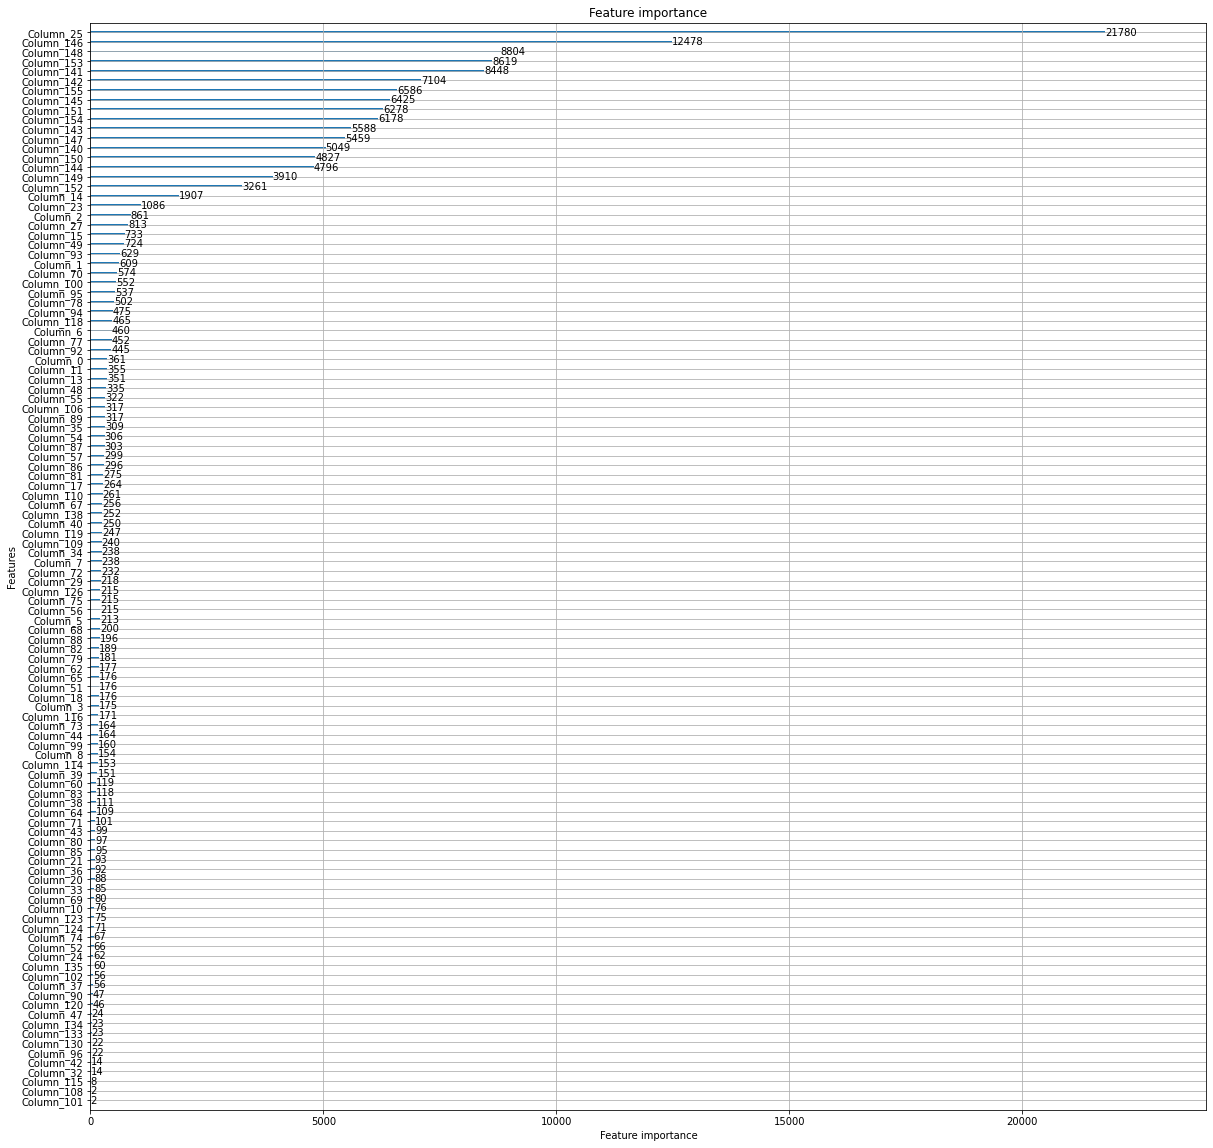

In [394]:
lightgbm.plot_importance(model, figsize=(20,20))


In [400]:
init_record.iloc[:, [25,146,148,153,141,142,155,145,151,154,143]]

incident_subcatgry_unknown_piv  \
_key_client_id                       _key_occurreddate_month                                   
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                           29   
                                     2019-05-01                                           31   
                                     2019-06-01                                           31   
                                     2019-07-01                                           32   
                                     2019-08-01                                           33   
...                                                                                      ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                           31   
                                     2019-10-01                                           32   
                                     2019-11-01                                           31   
                                     2019-12-01                                           32   
                                     2020-01-01                                           28   

                                                              prgcontct_client_piv  \
_key_client_id                       _key_occurreddate_month                         
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                  0   
                                     2019-05-01                                  0   
                                     2019-06-01                                  0   
                                     2019-07-01                                  1   
                                     2019-08-01                                  2   
...                                                                            ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                  0   
                                     2019-10-01                                  1   
                                     2019-11-01                                  1   
                                     2019-12-01                                  1   
                                     2020-01-01                                  0   

                                                              progsubjcat_case_discussion_planning_piv  \
_key_client_id                       _key_occurreddate_month                                             
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                                      1   
                                     2019-05-01                                                      0   
                                     2019-06-01                                                      0   
                                     2019-07-01                                                      1   
                                     2019-08-01                                                      2   
...                                                                                                ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                                      1   
                                     2019-10-01                                                      1   
                                     2019-11-01                                                      1   
                                     2019-12-01                                                      1   
                                     2020-01-01                                                      0   

                                                              progsubjcat_direct_support_shift_report_piv  \
_key_client_id                       _key_occurreddate_month                                                
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                                  